# Data Analysis

This data analysis is for: Toxic Comment Classification Challenge compeition in Kaggle

URL : https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

Data files required can be downloaded from here: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

Download and save the data in ./data/ folder relative to this Jupyter notebook

## Numerical Analysis

1. Read ./data/train.csv file
2. Counts no. of training data per class
3. A single comment can belong to multiple class


In [1]:
import csv

# labels provided with the data set
toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# non_toxic is label for comments belonging to none of the toxic_labels
labels_count = {'toxic' : 0,
                'severe_toxic' : 0,
                'obscene' : 0,
                'threat' : 0,
                'insult' : 0,
                'identity_hate' : 0,
                'non_toxic' : 0}

# read the CSV file
with open('./data/train.csv') as train_file:
    reader = csv.DictReader(train_file)
    total_row = 0
    for row in reader:
        total_row += 1
        is_none = True
        for label in toxic_labels:
            if(row[label] == '1'):
                labels_count[label] += 1
                is_none = False
        if(is_none):
            labels_count['non_toxic'] += 1
    print(labels_count)
    print(total_row)

{'toxic': 15294, 'severe_toxic': 1595, 'obscene': 8449, 'threat': 478, 'insult': 7877, 'identity_hate': 1405, 'non_toxic': 143346}
159571


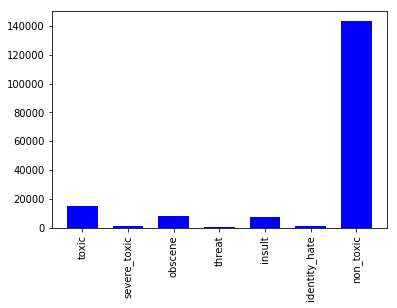

In [26]:
import matplotlib.pyplot as plt

plt.xticks(rotation=90)
plt.bar(labels_count.keys(), labels_count.values(), 1/1.5, color='b')
plt.show()

### Observations:
From above analysis we see that:
1. Total no. of data (training & validation) = 159,571
2. Total non-toxic comments = 143,346 (~ 89.83%)
3. Rest 10.17% of commets has one of the toxic label
4. Some of labels like threat, identity_hate, severe_toxic has very less samples compared to other labels

So this is imbalanced dataset as we can observe that data per class is highly imbalanced

## Language feature analysis

1. Understanding token (split comments into group of words) based features
2. Tokens histogram

In [3]:
texts = []
labels = []
toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
toxic_labels_id_map = {
    'non_toxic' : 0,
    'toxic' : 1,
    'severe_toxic' : 2,
    'obscene' : 3,
    'threat' : 4,
    'insult' : 5,
    'identity_hate' : 6
    }

num_rows_texts = 0
num_rows_labels = 0
with open('./data/train.csv') as train_file:
    reader = csv.DictReader(train_file)
    for row in reader:
        prev_row_count = num_rows_labels
        num_rows_texts += 1
        texts.append(row['comment_text'])
        is_none = True
        # check for labels other than toxic (1st label)
        for label in toxic_labels[1:]:
            if(row[label] == '1'):
                num_rows_labels += 1
                labels.append(toxic_labels_id_map[label])
                is_none = False
                break # a comments can have multiple labels but for now just take the 1st label <-- need to fix it
        if(is_none):
            num_rows_labels += 1
            # finally check if it is toxic or non-toxic
            if(row['toxic'] == '1'):
                labels.append(toxic_labels_id_map['toxic'])
            else:
                labels.append(toxic_labels_id_map['non_toxic'])
        if((num_rows_texts - num_rows_labels) < 0):
            print(row)
            break;

print(num_rows_texts)
print(num_rows_labels)

159571
159571


In [4]:
print('labels size:', len(labels))
labels[1:10]

labels size: 159571


[0, 0, 0, 0, 0, 2, 0, 0, 0]

# Tokenizing the data

Splitting the comments in to tokens, later used to create word vectors

In [5]:
from keras.preprocessing.text import Tokenizer

max_words = 10000 # consider only the tops 10,000 words in dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Using TensorFlow backend.


Found 210337 unique tokens.


### Get histogram

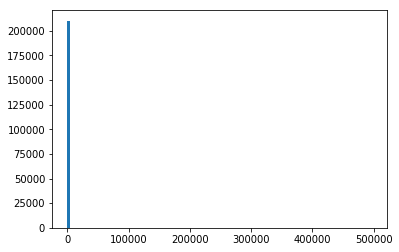

In [6]:
import numpy as np
#print(tokenizer.document_count)
# list of counts of words from map of word to its count
word_counts = list(tokenizer.word_counts.values())
#convert it to np array
word_counts_np = np.asarray(word_counts)
# create bin for histogram 
bins = np.arange(0, 300000, 100) # fixed bin size
#create history
plt.hist(word_counts_np, 100)
plt.show()

In [7]:
wc_np_s =  np.sort(word_counts_np)[::-1]

In [8]:
print(wc_np_s[1:100])

[297448 225041 224192 215749 206080 204397 176435 154532 145579 130323
 102949  97586  93754  89968  83463  77416  72225  72028  63365  59605
  58592  56039  54567  53405  51083  46268  45837  45619  44879  41511
  41435  40067  39545  37271  37203  36579  36420  34093  34073  31972
  31572  30715  30464  29780  29290  29244  28804  27994  27806  27318
  26811  25346  25126  24982  23700  23443  23238  22917  22586  22339
  21904  21596  21562  20624  20451  20071  19166  19108  18758  18261
  18242  17875  17873  17818  17723  17561  17545  17286  16750  16688
  16602  16205  15828  15606  15421  14936  14883  14732  14479  14327
  14310  13929  13898  13443  13389  12992  12777  12524  12426]


#### encoding the label data:
as it is multi class classification problem, the label need to be encoded into one hot encoding layer

In [10]:
from keras.utils.np_utils import to_categorical
one_hot_labels = to_categorical(labels)

### pad/truncate all comments to a fixed length
ToDo: do this padding per batch

In [12]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np
maxlen = 100 # cuts of comments after 100 words
data = pad_sequences(sequences, maxlen=maxlen)
one_hot_labels = np.asarray(one_hot_labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', one_hot_labels.shape)

Shape of data tensor: (159571, 100)
Shape of label tensor: (159571, 7)


## Split Data
#### Split the data into training data and validation data
#### Data can be shuffled (optional)

In [13]:
training_samples = 120000 # trains on 120,000 samples
validation_samples = 39571 # validates on 39,571 samples (rest)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
one_hot_labels = one_hot_labels[indices]
one_hot_labels = one_hot_labels[indices]

x_train = data[:training_samples]
y_train = one_hot_labels[:training_samples]

x_val = data[training_samples : training_samples + validation_samples]
y_val = one_hot_labels[training_samples : training_samples + validation_samples]

### GloVe (Global Vector) Word Embedding setup
download the glove precomputed imbedding from: https://nlp.stanford.edu/projects/glove
unzip it
it contains: 100 dimensional embedding vectors for 400,000 words from 2014 English Wikipedia

### preprocessing the embedding
#### Parsing the GloVe word-embedding file

In [14]:
import os

glove_dir = './data/glove/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


### Preparing the GloVe word-embedding matrix

1. Define embedding matrix dimension = embedding_dim (100) x max_words (10000 : defined above)
2. Iterated the word_idex and use top max_words to populated the embedding matrix using glove embedding_index

one can play with above params

In [15]:
embedding_dim = 100 # as we are using 100 dimensional glove index

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### Defining a Model

In [16]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM

model = Sequential()
# embedding layer
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
# RNN layer (LSTM)
model.add(LSTM(32))
# output layer (7 classes)
model.add(Dense(7, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 231       
Total params: 1,017,255
Trainable params: 1,017,255
Non-trainable params: 0
_________________________________________________________________


### Loading the GloVe embeddings in the model

In [17]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

### Training and evaluating the model

In [18]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')


Train on 120000 samples, validate on 39571 samples
Epoch 1/10
120000/120000 [==============================] - 148s 1ms/step - loss: 0.1162 - acc: 0.9707 - val_loss: 0.1136 - val_acc: 0.9710
Epoch 2/10
120000/120000 [==============================] - 149s 1ms/step - loss: 0.1139 - acc: 0.9709 - val_loss: 0.1141 - val_acc: 0.9710
Epoch 3/10
120000/120000 [==============================] - 152s 1ms/step - loss: 0.1143 - acc: 0.9709 - val_loss: 0.1136 - val_acc: 0.9710
Epoch 4/10
120000/120000 [==============================] - 150s 1ms/step - loss: 0.1144 - acc: 0.9709 - val_loss: 0.1185 - val_acc: 0.9710
Epoch 5/10
120000/120000 [==============================] - 155s 1ms/step - loss: 0.1147 - acc: 0.9709 - val_loss: 0.1169 - val_acc: 0.9710
Epoch 6/10
120000/120000 [==============================] - 154s 1ms/step - loss: 0.1155 - acc: 0.9709 - val_loss: 0.1151 - val_acc: 0.9710
Epoch 7/10
120000/120000 [==============================] - 155s 1ms/step - loss: 0.1157 - acc: 0.9709 - val_

### Plotting the training results

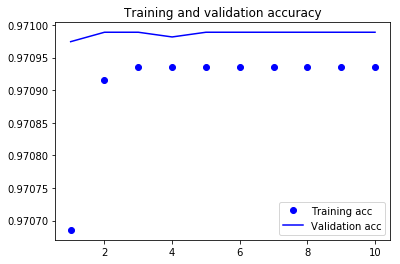

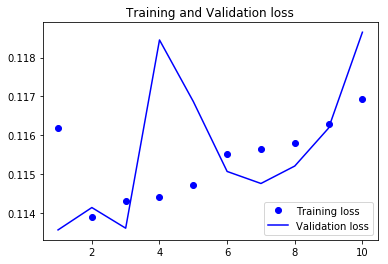

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()


## Testing the model on test data

#### Tokenizing the data of the test data set

In [20]:
test_texts = []
test_labels = []
test_id = []

with open('./data/test.csv') as test_file:
    reader = csv.DictReader(test_file)
    for row in reader:
        test_texts.append(row['comment_text'])
        test_id.append(row['id'])

test_sequences = tokenizer.texts_to_sequences(test_texts)
x_test = pad_sequences(test_sequences, maxlen=maxlen)


In [21]:
test_labels = model.predict(x_test)

In [22]:
print(test_labels[:10])

[[8.92731309e-01 4.47393358e-02 1.16734477e-02 4.25919145e-02
  1.31961671e-04 9.25851706e-03 7.58931856e-05]
 [9.03945029e-01 4.50319350e-02 6.77046273e-03 2.78621074e-02
  1.47376040e-05 3.89778032e-03 1.40552347e-05]
 [9.50790823e-01 6.79916702e-03 5.93067261e-06 9.21934750e-03
  3.90301551e-07 3.30328476e-05 1.06554488e-07]
 [8.94239366e-01 4.38396819e-02 1.10358335e-02 4.10116091e-02
  1.25614140e-04 8.88735615e-03 7.03711412e-05]
 [8.94495189e-01 4.37503718e-02 1.07460953e-02 4.12266478e-02
  1.08401167e-04 8.45914241e-03 6.34607350e-05]
 [8.92102718e-01 4.51185070e-02 1.19375940e-02 4.32384238e-02
  1.34820395e-04 9.41947475e-03 7.83044889e-05]
 [8.93217385e-01 4.41316590e-02 1.10897543e-02 4.13032249e-02
  1.29213091e-04 9.13032982e-03 7.34743080e-05]
 [9.04409707e-01 3.70080955e-02 7.43804779e-03 3.33712995e-02
  4.50239786e-05 5.51082101e-03 2.76693081e-05]
 [8.92763734e-01 4.33026813e-02 1.00875199e-02 4.35701162e-02
  6.58812933e-05 7.34710973e-03 3.89229062e-05]
 [9.159078

In [23]:
print(test_labels.shape)
print(len(test_texts))

(153164, 7)
153164


### save the test out in file

In [24]:
# same the labels only as csv
np.savetxt('./test_labels_out.csv', test_labels, delimiter=',', fmt='%f')

In [25]:
# save the test labels with id
test_pred_out = []
with open('test-result.csv', 'w') as f:
    f.write("id,toxic,severe_toxic,obscene,threat,insult,identity_hate\n")
    for i in range(0, len(test_id)):
        #print(i)
        f.write(test_id[i])
        f.write(',')
        #generate an array with strings
        x_arrstr = np.char.mod('%f', test_labels[i, 1:])
        #combine to a string
        x_str = ",".join(x_arrstr)
        f.write(x_str)#,0:])#.tolist))
        f.write('\n')